**Porcentaje de población de la ZM Ciudad de México que se siente inseguro en el transporte público**

In [1]:
rm(list = ls())

#Carga de librerias
libraries <- c("tidyverse",
               "srvyr", 
               "ggplot2")

installed_packages <- rownames(installed.packages())
libraries_to_install <- setdiff(libraries, installed_packages)

if (length(libraries_to_install) > 0) {
  install.packages(libraries_to_install)
}

lapply(libraries, library, character.only = TRUE)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Adjuntando el paquete: 'srvyr'


The following object is masked from 'package:stats':

    filter




[[1]]
 [1] "lubridate" "forcats"   "stringr"   "dplyr"     "purrr"     "readr"    
 [7] "tidyr"     "tibble"    "ggplot2"   "tidyverse" "stats"     "graphics" 
[13] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[2]]
 [1] "srvyr"     "lubridate" "forcats"   "stringr"   "dplyr"     "purrr"    
 [7] "readr"     "tidyr"     "tibble"    "ggplot2"   "tidyverse" "stats"    
[13] "graphics"  "grDevices" "utils"     "datasets"  "methods"   "base"     

[[3]]
 [1] "srvyr"     "lubridate" "forcats"   "stringr"   "dplyr"     "purrr"    
 [7] "readr"     "tidyr"     "tibble"    "ggplot2"   "tidyverse" "stats"    
[13] "graphics"  "grDevices" "utils"     "datasets"  "methods"   "base"

In [2]:
#Leeer tabla de victimas
leer_envipe_vic <- function(anio){
  # Lista de URLs por año
  urls <- list(
    "2016" = "https://www.inegi.org.mx/contenidos/programas/envipe/2016/microdatos/bd_envipe2016_dbf.zip",
    "2017" = "https://www.inegi.org.mx/contenidos/programas/envipe/2017/microdatos/bd_envipe2017_dbf.zip",
    "2018" = "https://www.inegi.org.mx/contenidos/programas/envipe/2018/microdatos/bd_envipe2018_dbf.zip",
    "2019" = "https://www.inegi.org.mx/contenidos/programas/envipe/2019/microdatos/bd_envipe2019_dbf.zip",
    "2020" = "https://www.inegi.org.mx/contenidos/programas/envipe/2020/microdatos/bd_envipe_2020_dbf.zip",
    "2021" = "https://www.inegi.org.mx/contenidos/programas/envipe/2021/microdatos/bd_envipe_2021_dbf.zip", 
    "2022" = "https://www.inegi.org.mx/contenidos/programas/envipe/2022/microdatos/bd_envipe_2022_dbf.zip", 
    "2023" = "https://www.inegi.org.mx/contenidos/programas/envipe/2023/microdatos/bd_envipe_2023_dbf.zip", 
    "2024" = "https://www.inegi.org.mx/contenidos/programas/envipe/2024/microdatos/bd_envipe_2024_dbf.zip")
  
  temp_zip <- tempfile(fileext = ".zip")
  temp_dir <- tempdir()
  options(timeout = 800)
  download.file(urls[[as.character(anio)]], temp_zip, mode = "wb")
  unzip(temp_zip, exdir = temp_dir)

  envipe_datos <- list.files(temp_dir, pattern = "TPer_Vic1.dbf", 
                             full.names = TRUE, recursive = TRUE)

  
  datos <- foreign::read.dbf(envipe_datos)
  
  unlink(temp_zip)
  unlink(list.files(temp_dir, full.names = TRUE), recursive = TRUE)
  
  return(datos)
}

In [3]:
#Crear variables para la población que ha respondido la pregunta
creacion_de_variable <- function(anio) {
  
  objeto_datos <- get(paste0("tpv", anio))
  
  mutate(objeto_datos, 
         POB = ifelse(!FAC_ELE_AM %in% "0",1,0), 
         se_t_publico = ifelse(AP4_4_09 %in% c("1","2"), "población con respuesta","sin respuesta"))|>
    filter(se_t_publico == "población con respuesta")|>
    mutate(inse_t_publico = ifelse(se_t_publico == "población con respuesta" & AP4_4_09 == "2", "Se siente inseguro", "No se siente inseguro"), 
         FAC_ELE_AM= as.numeric(FAC_ELE_AM))  
}

In [4]:
#Función para definir el diseño muestral
diseño_muestral <- function(anio) {
  
  objeto_datos <- get(paste0("tpv_", anio))
  
  as_survey_design(objeto_datos,
                   strata = EST_DIS,
                   weights = FAC_ELE_AM,
                   ids = UPM_DIS,
                   nest = TRUE)
}

In [5]:
#Obtener porcentajes y totales con coeficiente de variación
resultados_inseguridad <- function(anio) {
  datos <- get(paste0("inseg_tp_", anio))
  
  datos_dm <- datos |>
    group_by(inse_t_publico) |>
    summarise(tot_p_inseg_tp = survey_total(vartype = "cv"),
              porcentaje = survey_prop(vartype = "cv") * 100)|>
    filter(inse_t_publico == "Se siente inseguro")|>
    select(inse_t_publico, porcentaje, porcentaje_cv)|>
    mutate(ano = anio)
  
  return(datos_dm)
}

In [6]:
#Leer datos del la ENVIPE
tpv2016 <- leer_envipe_vic(2016) |>  
  filter(AREAM == "01")
tpv2017 <- leer_envipe_vic(2017) |>  
  filter(AREAM == "01")
tpv2018 <- leer_envipe_vic(2018) |>  
  filter(AREAM == "01")
tpv2019 <- leer_envipe_vic(2019) |>  
  filter(AREAM == "01")
tpv2020 <- leer_envipe_vic(2020) |>  
  filter(AREAM == "01")
tpv2021 <- leer_envipe_vic(2021) |>  
  filter(AREAM == "01")
tpv2022 <- leer_envipe_vic(2022) |>  
  filter(AREAM == "01")
tpv2023 <- leer_envipe_vic(2023) |>  
  filter(AREAM == "01")
tpv2024 <- leer_envipe_vic(2024) |>  
  filter(AREAM == "01")

In [7]:
#Creación de variable para cada año
tpv_2016<-creacion_de_variable(2016)
tpv_2017<-creacion_de_variable(2017)
tpv_2018<-creacion_de_variable(2018)
tpv_2019<-creacion_de_variable(2019)
tpv_2020<-creacion_de_variable(2020)
tpv_2021<-creacion_de_variable(2021)
tpv_2022<-creacion_de_variable(2022)
tpv_2023<-creacion_de_variable(2023)
tpv_2024<-creacion_de_variable(2024)

In [8]:
#Aplicar el diseño muestral para todos los años
inseg_tp_2016 <-diseño_muestral(2016)
inseg_tp_2017 <-diseño_muestral(2017)
inseg_tp_2018 <-diseño_muestral(2018)
inseg_tp_2019 <-diseño_muestral(2019)
inseg_tp_2020 <-diseño_muestral(2020)
inseg_tp_2021 <-diseño_muestral(2021)
inseg_tp_2022 <-diseño_muestral(2022)
inseg_tp_2023 <-diseño_muestral(2023)
inseg_tp_2024 <-diseño_muestral(2024)

In [9]:
p_inseg_tp_2016 <- resultados_inseguridad(2016)
p_inseg_tp_2017 <- resultados_inseguridad(2017)
p_inseg_tp_2018 <- resultados_inseguridad(2018)
p_inseg_tp_2019 <- resultados_inseguridad(2019)
p_inseg_tp_2020 <- resultados_inseguridad(2020)
p_inseg_tp_2021 <- resultados_inseguridad(2021)
p_inseg_tp_2022 <- resultados_inseguridad(2022)
p_inseg_tp_2023 <- resultados_inseguridad(2023)
p_inseg_tp_2024 <- resultados_inseguridad(2024)

In [11]:
inseguridad_transporte_publico <-p_inseg_tp_2016|>
  bind_rows(p_inseg_tp_2017, 
            p_inseg_tp_2018, 
            p_inseg_tp_2019, 
            p_inseg_tp_2020, 
            p_inseg_tp_2021,
            p_inseg_tp_2022, 
            p_inseg_tp_2023, 
            p_inseg_tp_2024)
            
            
 inseguridad_transporte_publico

inseguridad_transporte_publico<-inseguridad_transporte_publico|>
  select(porcentaje, ano)|>
  mutate(tipo = "Observado")


inseguridad_transporte_publico_2024 <- inseguridad_transporte_publico |> filter(ano == 2024)
inseguridad_transporte_publico_2016 <- inseguridad_transporte_publico |> filter(ano == 2016)


inse_t_publico,porcentaje,porcentaje_cv,ano
<chr>,<dbl>,<dbl>,<dbl>
Se siente inseguro,91.06742,0.6094179,2016
Se siente inseguro,92.76090,0.3820245,2017
Se siente inseguro,92.38835,0.3965878,2018
Se siente inseguro,92.87982,0.3883157,2019
Se siente inseguro,90.23521,0.4751848,2020
Se siente inseguro,90.54454,0.5478445,2021
Se siente inseguro,90.29368,0.5257166,2022
Se siente inseguro,85.93862,0.6127660,2023
Se siente inseguro,82.23606,0.6592955,2024


In [ ]:
##ESCENARIOS TENDENCIALES 2030,2035,2045
# Tasa de variación
tcma<-((inseguridad_transporte_publico_2024$porcentaje /inseguridad_transporte_publico_2016$porcentaje)^(1/(2024-2016)) - 1) 
tcma

inseguridad_transporte_publico_base <- inseguridad_transporte_publico |>
  filter(ano == 2024) |>
  pull(porcentaje)

inseguridad_transporte_publico_base

# Años a proyectar
años <- c(2030,2035,2045)
año_base <- 2024

tendencia_base <- data.frame(ano = años,
                             porcentaje = round(inseguridad_transporte_publico_base * (1 + -1/3*tcma) ^ (años - año_base), 2),
                             tipo = "Inercial")


tendecia_deseable<-data.frame(ano = años,
                              porcentaje = round(inseguridad_transporte_publico_base * (1 + 1/2*tcma) ^ (años - año_base), 2),
                              tipo = "Deseable")


tendecia_transformadora <-data.frame(ano = años,
                                     porcentaje = round(inseguridad_transporte_publico_base * (1 + 3/4*tcma) ^ (años - año_base), 2),
                                     tipo = "Transformador")


inseguridad_transporte_tendencias <- inseguridad_transporte_publico|>
  bind_rows(tendencia_base,tendecia_deseable, 
            tendecia_transformadora)|>
  select(ano, porcentaje, tipo)

inseguridad_transporte_tendencias


[1] -0.01266983

[1] 82.23606

ano,porcentaje,tipo
<dbl>,<dbl>,<chr>
2016,91.06742,Observado
2017,92.76090,Observado
2018,92.38835,Observado
2019,92.87982,Observado
2020,90.23521,Observado
2021,90.54454,Observado
2022,90.29368,Observado
2023,85.93862,Observado
2024,82.23606,Observado


In [13]:
lineas <- bind_rows(data.frame(ano = c(2024, 2030),
                               porcentaje = c(inseguridad_transporte_tendencias$porcentaje[inseguridad_transporte_tendencias$ano == 2024 & inseguridad_transporte_tendencias$tipo == "Observado"],
                                                            inseguridad_transporte_tendencias$porcentaje[inseguridad_transporte_tendencias$ano == 2030 & inseguridad_transporte_tendencias$tipo == "Inercial"]),
                               tipo = "Inercial"),
                    data.frame(ano = c(2024, 2030),
                               porcentaje = c(inseguridad_transporte_tendencias$porcentaje[inseguridad_transporte_tendencias$ano == 2024 & inseguridad_transporte_tendencias$tipo == "Observado"], 
                                                            inseguridad_transporte_tendencias$porcentaje[inseguridad_transporte_tendencias$ano == 2030 & inseguridad_transporte_tendencias$tipo == "Deseable"]),
                               tipo = "Deseable"), 
                    data.frame(ano = c(2024, 2030),
                               porcentaje = c(inseguridad_transporte_tendencias$porcentaje[inseguridad_transporte_tendencias$ano == 2024 & inseguridad_transporte_tendencias$tipo == "Observado"], 
                                                            inseguridad_transporte_tendencias$porcentaje[inseguridad_transporte_tendencias$ano == 2030 & inseguridad_transporte_tendencias$tipo == "Transformador"]),
                               tipo = "Transformador"))


paleta_colores <- c("Observado" = "#9F2241",
                    "Inercial" = "#cfcfcf" ,
                    "Deseable" = "#027A35", 
                    "Transformador" = "#AC6D14")

linetypes <- c("Observado" = "solid",
               "Inercial" = "dotdash",
               "Deseable" = "dotdash", 
               "Transformador" = "dotdash")


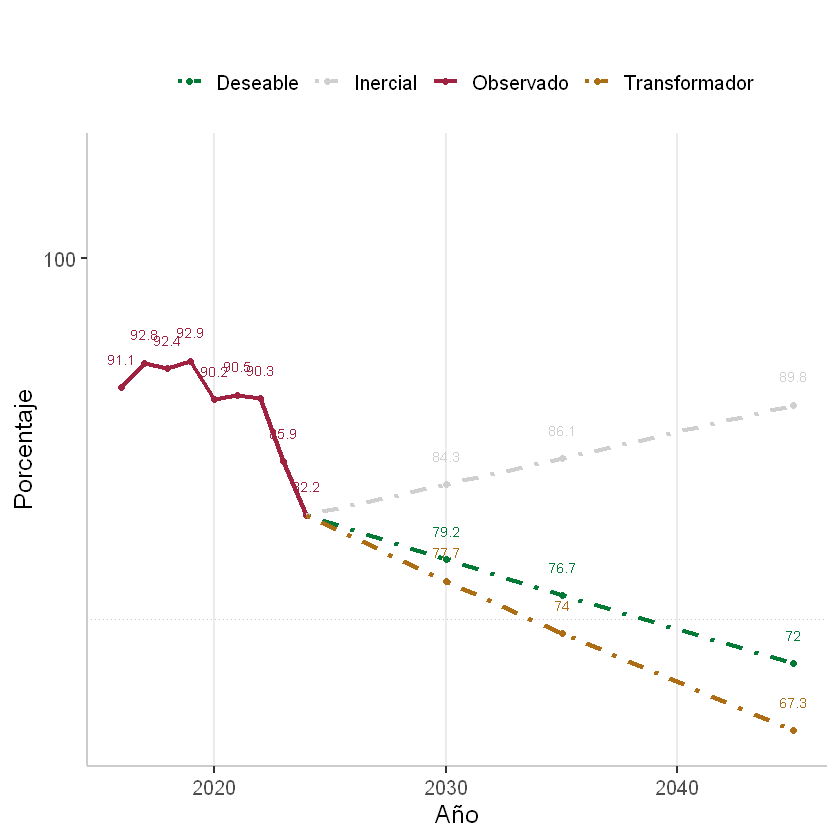

In [14]:
# Gráfico con etiquetas y eje Y personalizado
ggplot(inseguridad_transporte_tendencias, aes(x = ano, y = porcentaje, group = tipo, color = tipo, linetype = tipo)) +
  geom_line(linewidth = 1.2) +
  geom_point(size = 1.5) +
  geom_line(data = lineas, aes(x = ano, y = porcentaje, group = tipo), linewidth = 1.2) +
  geom_text(aes(label = round(porcentaje, 1)),
            position = position_nudge(y = 2),
            size = 3, show.legend = FALSE) +
  scale_color_manual(values = paleta_colores) +
  scale_linetype_manual(values = linetypes) +
  scale_y_continuous(breaks = seq(0, max(inseguridad_transporte_tendencias$porcentaje, na.rm = TRUE) +100, by = 50),
                     labels = function(x) paste0(x, ""),
                     expand = expansion(mult = c(0.09,0.5))) +
  labs(title = "",
       x = "Año",
       y = "Porcentaje",
       color = "",
       linetype = "") +
  theme_bw(base_size = 15) +
  theme( panel.grid.minor.y = element_line(color = "gray80", linetype = "dotted"),
         panel.grid.minor.x = element_blank(),
         panel.grid.major.y = element_blank(),
         panel.border = element_blank(),
         axis.line = element_line(color = "gray80"),
         legend.position = "top",
         plot.caption = element_text(hjust = 100))

ggsave("inseguridad_transporte_tendencias.png", width = 8, height = 5, dpi = 300)